In [59]:
import os
import sys

import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
from itertools import product

import scvi

SCRIPT_DIR = os.path.dirname(os.getcwd())
SCRIPT_DIR += '/src/inVAE'
sys.path.append(os.path.dirname(SCRIPT_DIR))
from inVAE.utils import sparse_shift, mcc, get_linear_score
%load_ext autoreload
%autoreload 2

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
n_batches = 3
n_cell_types = 2
n_disease_states = 2
n_cells_per_comb = 500
#n_chem: int = 100
n_latent_inv = 9
n_latent_spur = 1
n_genes = 100

# Use defaults or params?
shift_cell_type = [5, 2]
shift_disease = [0, 1]
var_batch = [1, 2, 3]

In [51]:
n_latent = n_latent_inv + n_latent_spur
combs = list(product(range(n_cell_types), range(n_disease_states)))
n_combs = len(combs)

# start by generating target mean for every combination of cell type and disease state
targets = np.ones((n_combs, n_latent))

targets[:,n_latent_inv:] = 0

# now generate shifts and apply mask to get target effects
shift_sign = (
    2 * (np.random.uniform(0, 1, size=targets.shape) > 0.5).astype(float) - 1
)

shift_abs = np.zeros(shape=targets.shape)
for i, comb in enumerate(combs):
    shift_cell_tmp = shift_cell_type[comb[0]]
    shift_disease_tmp = shift_disease[comb[1]]
    shift_abs[i,:n_latent_inv] = np.random.normal(shift_cell_tmp + shift_disease_tmp, 0.5, size=(1, n_latent_inv))

action_specific_prior_mean = targets * shift_abs * shift_sign

# now we can go around simulating cells and z for all those cells
z = np.zeros((n_batches * n_combs * n_cells_per_comb, n_latent))
cells_per_batch = n_combs * n_cells_per_comb
for batch in range(n_batches):
    var_tmp = np.eye(n_latent)
    var_tmp[range(n_latent_inv, n_latent), range(n_latent_inv, n_latent)] += var_batch[batch]
    for comb in range(n_combs):
        z[
            (batch * cells_per_batch) + (comb * n_cells_per_comb) : (batch * cells_per_batch) + ((comb+1) * n_cells_per_comb) 
        ] = np.random.multivariate_normal(
            action_specific_prior_mean[comb], var_tmp, size=(n_cells_per_comb)
        )

In [52]:
z.shape

(6000, 10)

In [32]:
adata = sparse_shift(
    n_cells_per_comb = 500,
    n_batches = 2,
    n_cell_types = 2,
    n_disease_states = 3,
    n_latent_inv = 8,
    n_latent_spur = 2,
    n_genes = 100,
    shift_cell_type = [20., 100.],
    shift_disease = [0., 1.1, 1.3],
    mean_batch= [1., 2.],
    var_batch = [1., 2.]
)

Mean for experiment:
[[ 20.88202617  20.2000786   20.48936899  21.1204466   20.933779
   19.51136106  20.47504421  19.9243214    1.           1.        ]
 [ 21.04839057  21.30529925  21.17202179  21.82713675  21.48051886
   21.16083751  21.32193162  21.26683716   1.           1.        ]
 [ 22.04703954  21.19742087  21.45653385  20.87295213  20.02350509
   21.6268093   21.7322181   20.92891749   1.           1.        ]
 [101.13487731  99.27281716 100.02287926  99.90640807 100.76638961
  100.73467938 100.07747371 100.18908126   1.           1.        ]
 [100.65610713 100.10960177 100.92604393 101.17817448 101.71514534
  101.70118992 100.90633659 100.94884862   1.           1.        ]
 [100.77572352 100.58999103 100.4468649  102.2753877  101.04517391
  101.08096285 100.67360232 101.68874518   1.           1.        ]]
Mean for experiment:
[[ 20.88202617  20.2000786   20.48936899  21.1204466   20.933779
   19.51136106  20.47504421  19.9243214    2.           2.        ]
 [ 21.04839057  

In [33]:
adata

AnnData object with n_obs × n_vars = 6000 × 100
    obs: 'batch', 'cell_type', 'disease'
    uns: 'prior_mean'
    obsm: 'groundtruth_latent'

/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


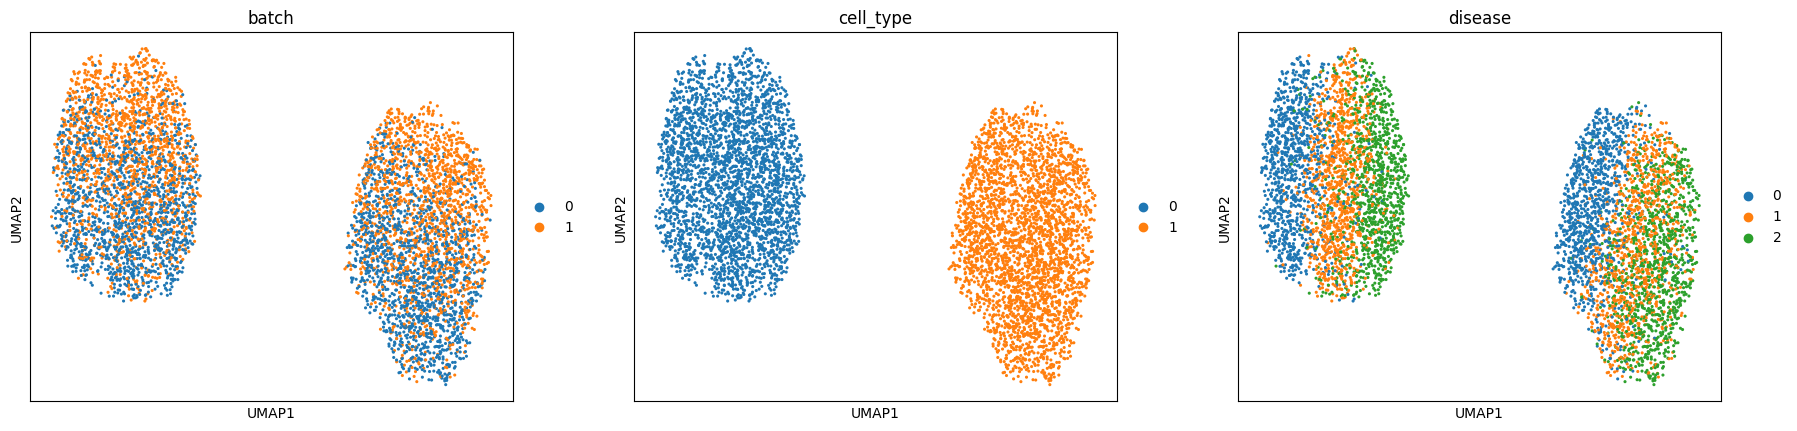

In [34]:
sc.pp.neighbors(adata, use_rep='groundtruth_latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

[autoreload of inVAE.utils failed: Traceback (most recent call last):
  File "/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ferdi/inVAE/src/inVAE/utils/__init__.py", line 3, in <module>
    from ._simulation import sparse_shift, mcc, get_linear_score
ImportError: cannot import name 'mcc' from 'inVAE.utils._simulation' (/home/ferdi/inVAE/src/inVAE/utils/_simulation.py)
]
/home/ferdi/inVAE/invaevenv/lib/py

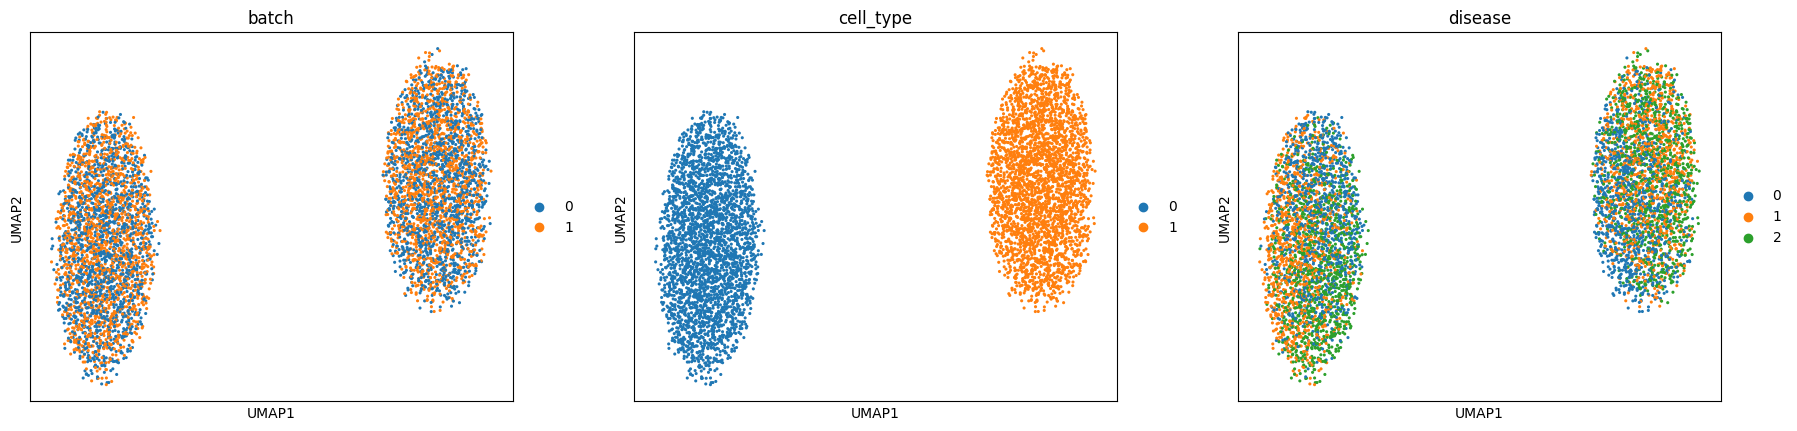

In [35]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

In [40]:
adata.obsm['groundtruth_latent_inv'] = adata.obsm['groundtruth_latent'][:,:8]
adata.obsm['groundtruth_latent_spur'] = adata.obsm['groundtruth_latent'][:,8:]

/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


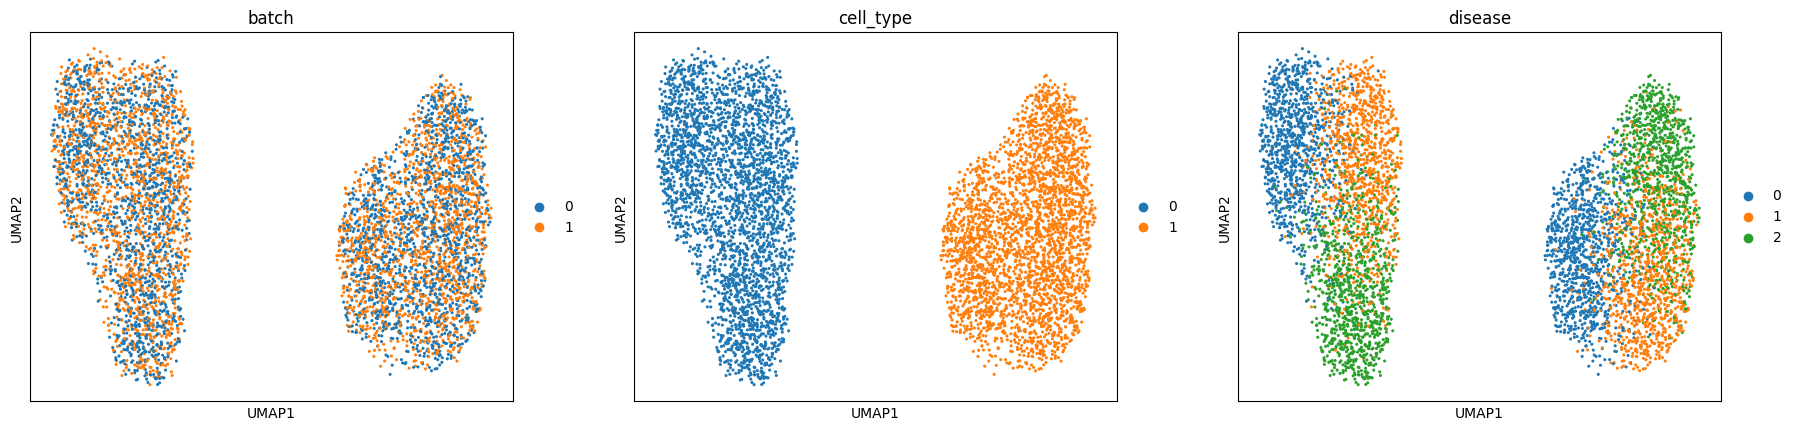

In [41]:
sc.pp.neighbors(adata, use_rep='groundtruth_latent_inv')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


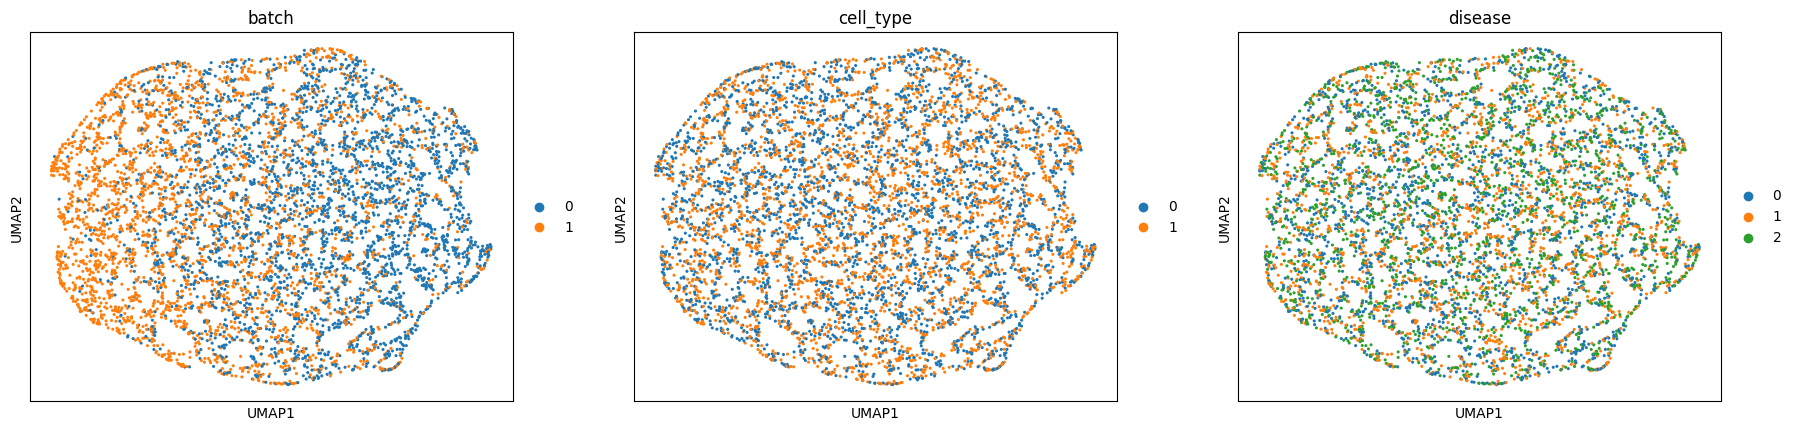

In [42]:
sc.pp.neighbors(adata, use_rep='groundtruth_latent_spur')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

In [43]:
import matplotlib.pyplot as plt

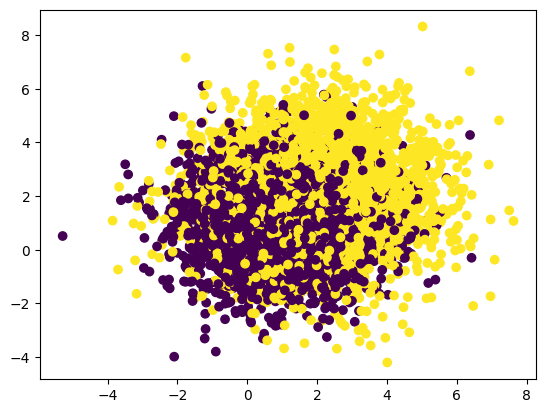

In [44]:
plt.scatter(adata.obsm['groundtruth_latent_spur'][:,0], adata.obsm['groundtruth_latent_spur'][:,1], c = adata.obs['batch'])

Numbers:

mean = (mean_cell_type + mean_disease, mean_batch)



In [45]:
from inVAE import FinVAE

In [49]:
inv_covar_keys = {
    'cont': [],
    'cat': ['cell_type', 'disease'] #set to the keys in the adata
}

spur_covar_keys = {
    'cont': [],
    'cat': ['batch'] #set to the keys in the adata
}

model = FinVAE(
    adata = adata,
    layer = None, # The layer where the raw counts are stored in adata (None for adata.X: default)
    latent_dim_inv=8,
    latent_dim_spur=2,
    inv_covar_keys = inv_covar_keys,
    spur_covar_keys = spur_covar_keys,
    elbo_version='sample'
)

model.train(n_epochs = 500, lr_train=0.001, weight_decay=0.0001)

Layer is None, check if you want to specify the layer of adata!
Data loading done!
Defaulting to printing training loss every 100 epochs. If you want a different number, set it for the train function!
Starting training of model:
	epoch 100/500 took 0.37s; loss: 491.72
	epoch 200/500 took 0.38s; loss: 426.98
	epoch 300/500 took 0.44s; loss: 407.05
	epoch 400/500 took 0.41s; loss: 403.75
	epoch 500/500 took 0.39s; loss: 403.19
Training done!


Using saved adata for latent representation!


/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


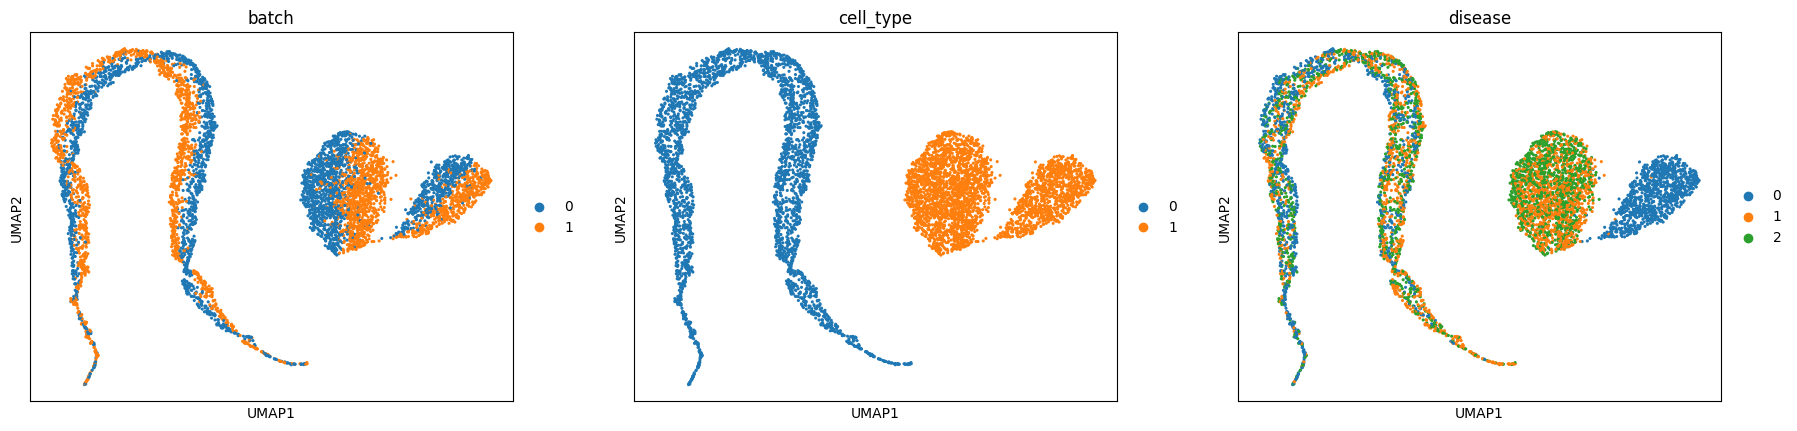

In [50]:
adata.obsm['X_FinVAE'] = model.get_latent_representation(latent_type='inv')

sc.pp.neighbors(adata, use_rep='X_FinVAE')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

Using saved adata for latent representation!


/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


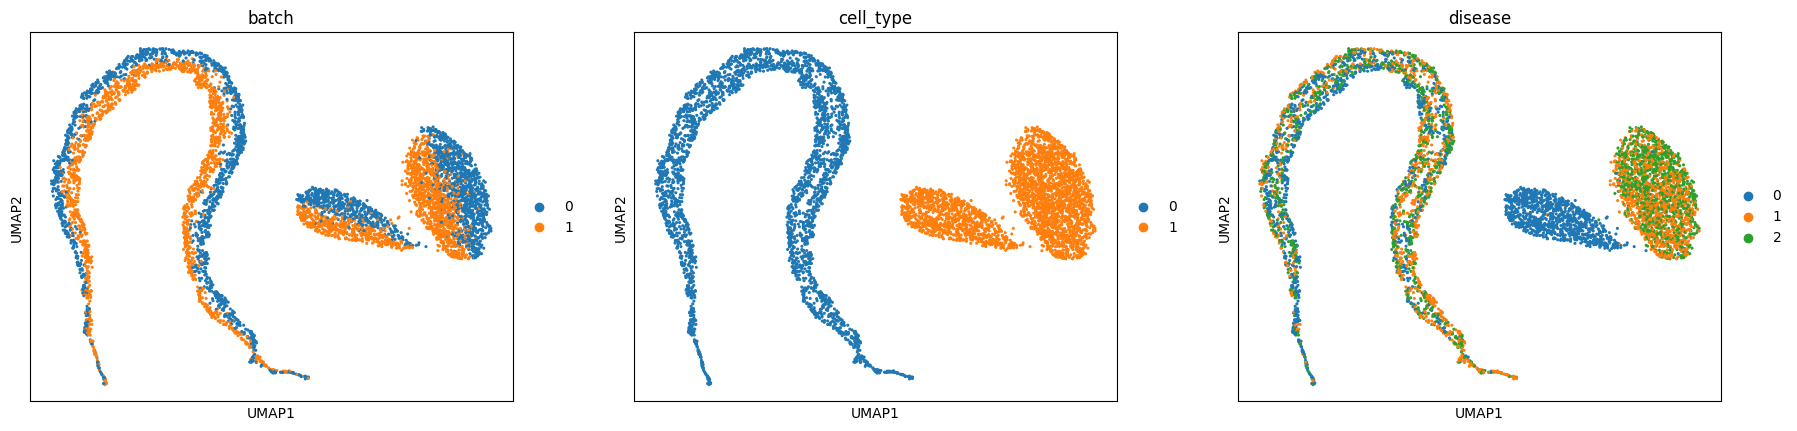

In [56]:
adata.obsm['X_FinVAE_full'] = model.get_latent_representation(latent_type='full')

sc.pp.neighbors(adata, use_rep='X_FinVAE_full')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','cell_type','disease'])

# scANVI

In [62]:
adata.obs['cell_type']

0       1
1       0
2       0
3       0
4       0
       ..
5995    1
5996    0
5997    0
5998    0
5999    1
Name: cell_type, Length: 6000, dtype: category
Categories (2, int64): [0, 1]

In [61]:
scvi.model.SCANVI.setup_anndata(
    adata,
    layer=None,
    batch_key="batch", 
    labels_key="cell_type",
    unlabeled_category = "Unknown"
)

model = scvi.model.SCANVI(adata)

model.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scvi/data/fields/_scanvi.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._unlabeled_category in labels:
/home/ferdi/inVAE/invaevenv/lib/python3.8/site-packages/scvi/data/fields/_scanvi.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self._unlabeled_category not in mapping:


ValueError: Making .obs["cell_type"] categorical failed. Expected categories: ['0' '1' 'Unknown']. Received categories: Index([0, 1], dtype='int64'). 

# Measures

In [51]:
adata.obsm['X_FinVAE_full'] = model.get_latent_representation(latent_type='full')

Using saved adata for latent representation!


In [55]:


gt_latent = adata.obsm['groundtruth_latent']

mcc_score = mcc(gt_latent, adata.obsm['X_FinVAE_full'], method='pearson')
mcc_score_spearman = mcc(gt_latent, adata.obsm['X_FinVAE_full'], method='spearman')

r2 = get_linear_score(gt_latent, adata.obsm['X_FinVAE_full'])

print(f'MCC pearson score: {mcc_score}')
print(f'MCC spearman score: {mcc_score_spearman}')
print(f'R2 score: {r2}')

MCC pearson score: 0.8161629886954082
MCC spearman score: 0.6624382302074125
R2 score: 0.8745259095504956
